# XGBOOST Explanation

This notebook is focused on the explanation of the XGBoost model used to perform the `Task 4: classification`.

## Preparation of the model

In [1]:
from os import path
import pandas as pd
from preprocessing import get_train_test_data
from transformations import center_and_scale, drop_boolean
train_data, train_labels, test_data, test_labels, columns_to_keep = get_train_test_data()

# casting of boolean columns to int, necessary for SHAP to work
train_data = train_data.astype({col: 'int' for col in train_data.select_dtypes('bool').columns})
test_data = test_data.astype({col: 'int' for col in test_data.select_dtypes('bool').columns})

full_dataset = pd.concat((train_data, test_data))

In [2]:
print(train_data.dtypes)

bmi                      float64
career_points            float64
career_duration(days)    float64
debut_year               float64
difficulty_score         float64
competitive_age            int64
is_tarmac                  int64
climbing_efficiency      float64
startlist_quality          int64
avg_pos                  float64
dtype: object


In [3]:
import pandas as pd
result = pd.read_csv('xgboostresult.csv').sort_values(by='val_f1_score',ascending=False).head(10)
result

,gamma,lambda,learning_rate,max_depth,min_child_weight,n_estimators,scale_pos_weight,train_f1_score,val_f1_score
465,0.0,2,1.0,3,1,250,1,0.880052,0.880052
1761,0.2,2,1.0,3,1,250,1,0.880052,0.880052
1113,0.1,2,1.0,3,1,250,1,0.880052,0.880052
1545,0.2,1,1.0,3,1,250,1,0.879643,0.879643
51,0.0,0,1.0,3,3,250,1,0.879596,0.879596
699,0.1,0,1.0,3,3,250,1,0.879596,0.879596
1347,0.2,0,1.0,3,3,250,1,0.879596,0.879596
1122,0.1,2,1.0,3,2,250,1,0.879364,0.879364
1770,0.2,2,1.0,3,2,250,1,0.879364,0.879364
474,0.0,2,1.0,3,2,250,1,0.879364,0.879364


In [4]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(
        gamma=0.0,
        reg_lambda=2,
        learning_rate=1.0,
        max_depth=3,
        min_child_weight=1,
        n_estimators=250,
        scale_pos_weight=1
)


xgbc.fit(train_data, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [5]:
from sklearn.metrics import classification_report

train_labels_model = xgbc.predict(train_data)
test_labels_model = xgbc.predict(test_data)
validation = classification_report(test_labels, test_labels_model, output_dict=True)

In [6]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                            test_pred,
                            target_names=['0', '1']))

In [7]:
report_scores(test_labels, test_labels_model)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     30219
           1       0.42      0.17      0.25      5187

    accuracy                           0.84     35406
   macro avg       0.65      0.57      0.58     35406
weighted avg       0.81      0.84      0.82     35406



# Feature importance

In [8]:
perturbation_data = train_data
perturbation_labels = train_labels
perturbation_predictions = train_labels_model

explanation_data = test_data
explanation_labels = test_labels
explanation_predictions = test_labels_model

explanations = dict()

Here we we will analyse the feature importance of the Random Forest model that we have trained above. To do so, we will use the `shap` library. 
In particular, we will use the `shap.TreeExplainer` class to explain the predictions of the model because it is a tree-based model and it is the most appropriate class for this type of model.

In [9]:
import shap


interventional_explanation_algorithm = shap.TreeExplainer(
    model=xgbc,
    data=train_data,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)


distributional_explanation_algorithm = shap.TreeExplainer(
    model=xgbc,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)


In [10]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

100%|===================| 35322/35406 [01:18<00:00]        

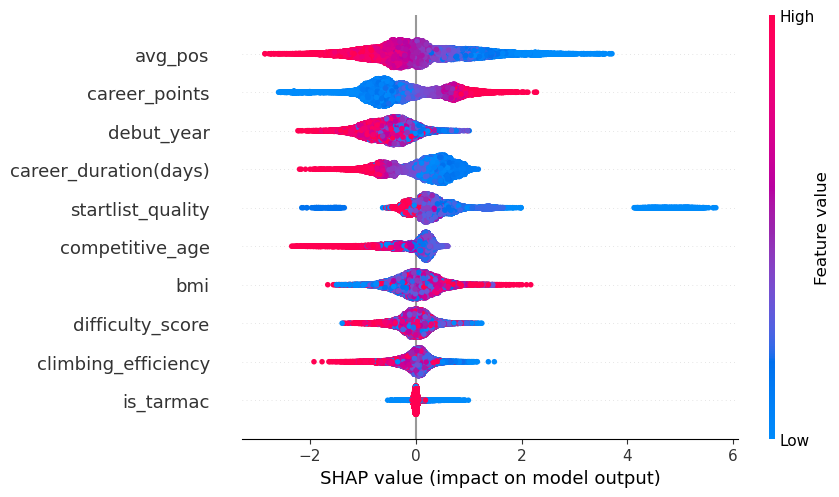

In [11]:
shap.plots.beeswarm(interventional_explanations)

The plot shows on the Y-axis the name of the features ordered by their impact on the model output, on the X-axis the SHAP values. The color of the points represents the value of the feature from low to high.
The plot is generated with `interventional` perturbation method that takes into account relationships in the data.

Looking at it we can say that:
- `career_points` has a strong positive impact on the model's output when the values are high and a negative impact when the values are low.
- `avg_pos` has mostly negative SHAP values when the feature value is high, suggesting that worse positions reduce the model's output.

- Longer `career_duration(days)` generally contribute positively to the model's predictions.

- `startlist_quality` shows a positive impact for low values
- high `competitive_age` has a mostly negative impact on the model's output.


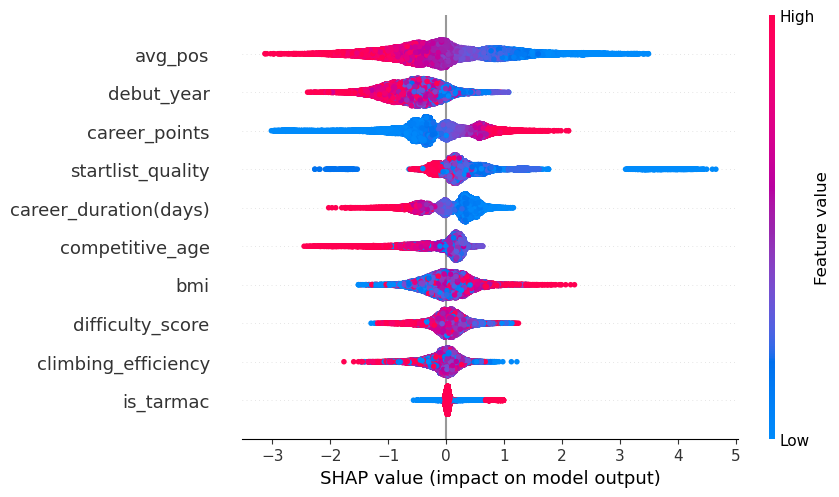

In [12]:
shap.plots.beeswarm(distributional_explanations)

This plot has been made by using the `tree_path_dependent` method where the feature impacts are reflected by the tree during training.
From the graph we can say that:
- `avg_pos` has the highest impact where higher values have a negative impact on the model's output.
- `career_points` has mostly a negative impact on the model's output when the values are low and a positive impact when the values are high.
- `debut year` has a negative impact for high values.
- `career_duration(days)` has a positive impact on the model's output mostly.

## Perturbation differences in Shap

Now we study the distribution of maximum differences per instance between the SHAP values obtained using interventional and tree_path_dependent perturbation methods.

In [13]:
import seaborn


explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

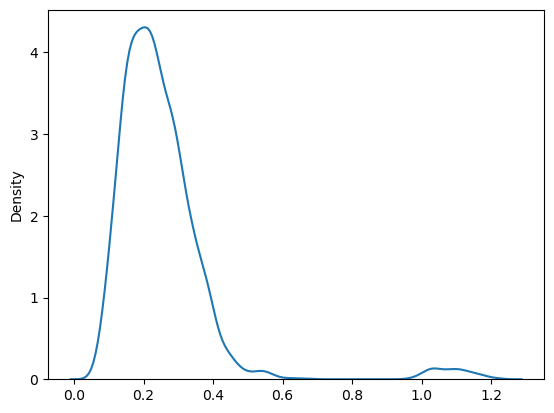

In [14]:
seaborn.kdeplot(maximum_differences_per_instance)

Here the X-axis represents the maximum difference between the SHAP values obtained using the two perturbation methods, while the Y-axis represents the density of the instances.

Most instances have a maximum SHAP differece around 0.2 indicating that the two methods are not very different in their predictions, the two explanation methods yield fairly similar results with small differences. The density drops after 0.6, indicating that large differences are rare, indicating that the two methos mostly align in their predictions..

Now we study which features have the highest differences in SHAP values between the two perturbation methods.

['bmi', 'career_points', 'career_duration(days)', 'debut_year', 'difficulty_score', 'competitive_age', 'is_tarmac', 'climbing_efficiency', 'startlist_quality', 'avg_pos']


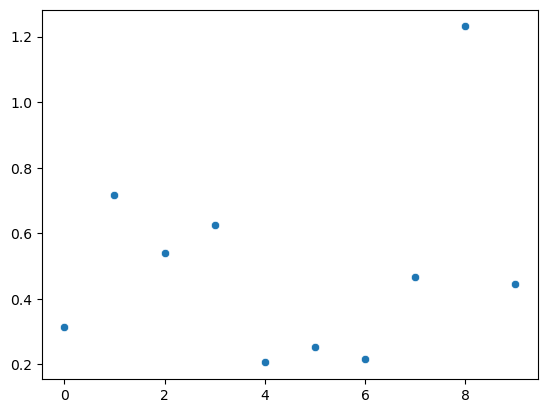

In [15]:
seaborn.scatterplot(maximum_differences_per_feature)
print(train_data.columns.tolist())

From the plot we can tell that `startlist_quality` has the highest maximum difference (around 1.2). This means that the two methods diverge significantly for this feature, other features like `bmi` and `competitive_age` are less affeccted by the chosen perturbation method and have in both methods impact similarly, other features like `debut_year` and `climbing_efficiency` fall in between, showing moderate differences.

## Explanation analysis

Are some features generally more impactful?

In [16]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
interventional_explanations_df.describe().drop("count", axis="rows")

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos
mean,0.021518,-0.229302,0.120179,-0.500870,-0.024631,-0.079618,0.014409,-0.024371,0.379238,0.041360
std,0.380928,0.701816,0.536170,0.405227,0.275990,0.432428,0.082145,0.283566,0.766161,0.884060
min,-1.665596,-2.595358,-2.199224,-2.229603,-1.394044,-2.347060,-0.531828,-1.925833,-2.156511,-2.853192
25%,-0.214262,-0.717385,-0.318924,-0.786782,-0.174858,-0.294256,-0.016232,-0.148285,0.061772,-0.511852
50%,0.019801,-0.385624,0.254803,-0.472662,-0.006881,0.097565,0.002681,0.015705,0.254226,-0.066889
75%,0.258790,0.329494,0.526587,-0.218273,0.151921,0.213202,0.017848,0.138187,0.495149,0.565835
max,2.173209,2.281237,1.181628,1.009097,1.248245,0.605753,0.993828,1.484720,5.672880,3.708761


From the table we can see that `debut_year` has the highest absolute value of SHAP values, indicating that it is the most impactful feature in the model, while `is_tarmac` is the least impactful feature. Based on the `mean` and `std` values, we can say that the most impactful features are (in order):
- `debut_year`
- `startlist_quality`
- `career_points`
- `career_duration(days)`
- `avg_pos`

For what instances are some features more/less impactful?

<Axes: xlabel='debut_year', ylabel='Density'>

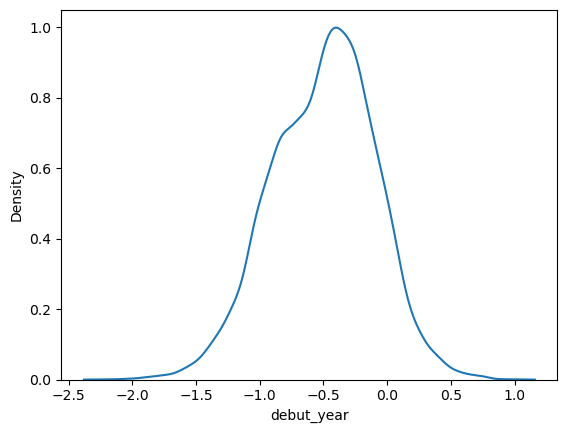

In [17]:
feature_of_interest = "debut_year"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [18]:
number_quantiles = 40
quantiles = interventional_explanations_df["debut_year"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    0.912212
0.050    0.137369
0.075    0.089112
0.100    0.059527
0.125    0.050028
0.150    0.044805
0.175    0.041541
0.200    0.038518
0.225    0.034908
0.250    0.034801
0.275    0.036384
0.300    0.034086
0.325    0.032893
0.350    0.034861
0.375    0.032182
0.400    0.032051
0.425    0.031596
0.450    0.027862
0.475    0.026397
0.500    0.025809
0.525    0.025710
0.550    0.024081
0.575    0.024596
0.600    0.025058
0.625    0.025267
0.650    0.025050
0.675    0.025559
0.700    0.026497
0.725    0.025602
0.750    0.026967
0.775    0.030086
0.800    0.031060
0.825    0.033510
0.850    0.036557
0.875    0.040645
0.900    0.043569
0.925    0.052909
0.950    0.067198
0.975    0.128991
Name: debut_year, dtype: float64

<Axes: xlabel='startlist_quality', ylabel='Density'>

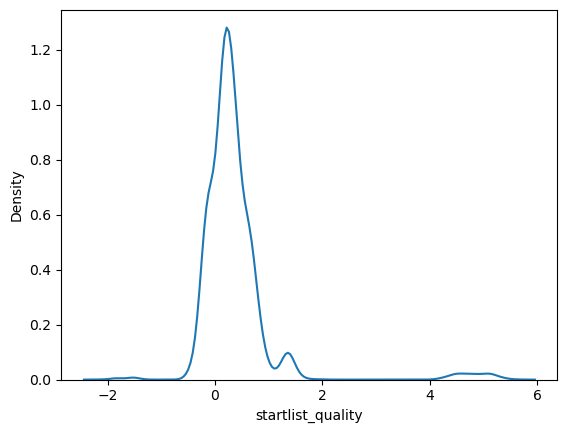

In [19]:
feature_of_interest = "startlist_quality"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [20]:
number_quantiles = 40
quantiles = interventional_explanations_df["startlist_quality"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    1.878818
0.050    0.057180
0.075    0.038475
0.100    0.033286
0.125    0.030957
0.150    0.032886
0.175    0.033456
0.200    0.039601
0.225    0.041184
0.250    0.032440
0.275    0.027691
0.300    0.023749
0.325    0.019429
0.350    0.017360
0.375    0.017054
0.400    0.016158
0.425    0.016954
0.450    0.018365
0.475    0.017151
0.500    0.018544
0.525    0.018691
0.550    0.019675
0.575    0.019364
0.600    0.019166
0.625    0.021489
0.650    0.022483
0.675    0.024484
0.700    0.026351
0.725    0.030665
0.750    0.038556
0.775    0.040798
0.800    0.040920
0.825    0.042053
0.850    0.040185
0.875    0.042951
0.900    0.053885
0.925    0.095961
0.950    0.420086
0.975    0.247611
Name: startlist_quality, dtype: float64

<Axes: xlabel='career_points', ylabel='Density'>

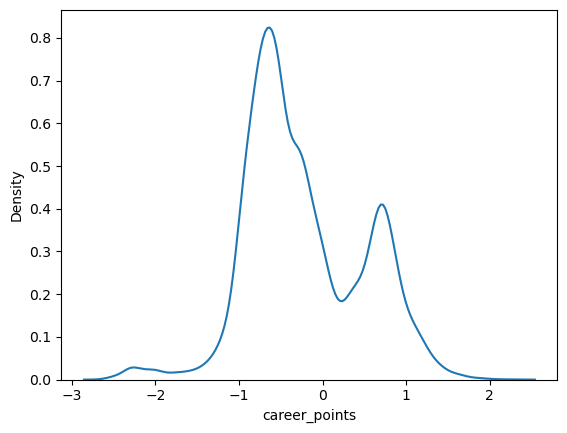

In [21]:
feature_of_interest = "career_points"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [22]:
number_quantiles = 40
quantiles = interventional_explanations_df["career_points"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    1.222966
0.050    0.284152
0.075    0.096474
0.100    0.051651
0.125    0.043739
0.150    0.044337
0.175    0.037667
0.200    0.036120
0.225    0.031993
0.250    0.028871
0.275    0.027955
0.300    0.030354
0.325    0.030173
0.350    0.030910
0.375    0.026793
0.400    0.028044
0.425    0.033118
0.450    0.032665
0.475    0.041790
0.500    0.049962
0.525    0.047873
0.550    0.044018
0.575    0.042338
0.600    0.044762
0.625    0.052640
0.650    0.063596
0.675    0.068650
0.700    0.076150
0.725    0.129868
0.750    0.145223
0.775    0.107206
0.800    0.110786
0.825    0.073687
0.850    0.058776
0.875    0.049863
0.900    0.060076
0.925    0.071896
0.950    0.100315
0.975    0.179565
Name: career_points, dtype: float64

<Axes: xlabel='career_duration(days)', ylabel='Density'>

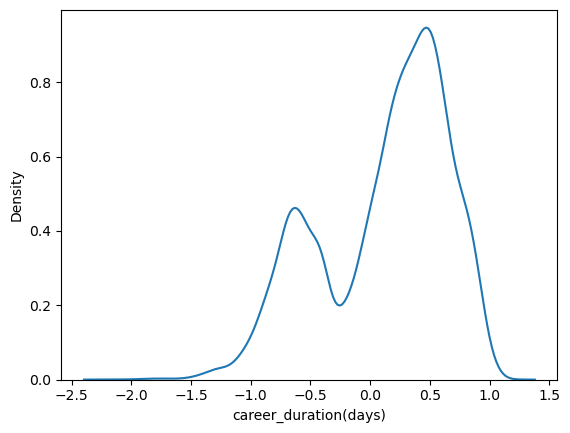

In [23]:
feature_of_interest = "career_duration(days)"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

number_quantiles = 40
quantiles = interventional_explanations_df["career_duration(days)"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

<Axes: xlabel='avg_pos', ylabel='Density'>

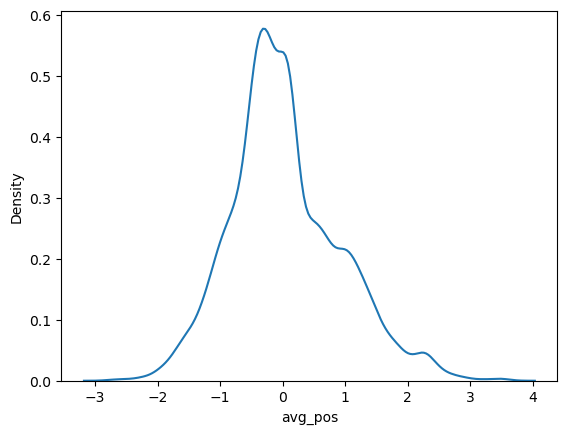

In [24]:
feature_of_interest = "avg_pos"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [25]:
number_quantiles = 40
quantiles = interventional_explanations_df["avg_pos"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    1.319147
0.050    0.255683
0.075    0.161982
0.100    0.115307
0.125    0.103296
0.150    0.092209
0.175    0.087142
0.200    0.080640
0.225    0.070090
0.250    0.055843
0.275    0.049913
0.300    0.042184
0.325    0.040881
0.350    0.043798
0.375    0.041661
0.400    0.039746
0.425    0.043096
0.450    0.045243
0.475    0.045827
0.500    0.052614
0.525    0.048446
0.550    0.044423
0.575    0.041014
0.600    0.042452
0.625    0.047774
0.650    0.051013
0.675    0.073018
0.700    0.098186
0.725    0.094111
0.750    0.092288
0.775    0.103346
0.800    0.104585
0.825    0.117552
0.850    0.117548
0.875    0.114725
0.900    0.129871
0.925    0.158846
0.950    0.225969
0.975    0.430656
Name: avg_pos, dtype: float64

The output shows a large initial differente from quantile 0 to 0.025 indicating that the SHAP values for `startlist_quality` at the lower end of the distribution vary more significantly than higher quantiles.

This means that the feature `startlist_quality` has a high impact on predictions for instances where its value is very low.

In [26]:
import numpy

quantile_of_interest = quantiles[0.1]
interested_explanations = interventional_explanations_df[feature_of_interest].values

highly_impacted_instances = numpy.argwhere(interested_explanations <= quantile_of_interest).squeeze()
moderately_impacted_instances = numpy.array([i for i in range(interventional_explanations.shape[0]) if i not in highly_impacted_instances])

## What are the differences in instances for which the selected features is highly important?

In [27]:
full_dataset.iloc[highly_impacted_instances].describe().drop("count", axis="rows") - full_dataset.iloc[moderately_impacted_instances].describe().drop("count", axis="rows")

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos
mean,-0.026724,667.193188,13.317349,4.957051,0.024033,-0.147608,-0.000964,-0.001194,-6.047830,1.375664
std,-0.201340,-1619.881235,-15.682292,-2.182677,0.001143,-0.060128,0.001684,0.000953,0.051938,0.647175
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000454,146.000000,0.000000
25%,0.061971,1290.000000,18.000000,25.000000,0.007872,0.000000,0.000000,0.000077,0.000000,0.210425
50%,0.135851,2195.000000,38.000000,2.000000,0.027474,0.000000,0.000000,0.000109,-39.000000,7.454130
75%,-0.070805,1125.778365,24.000000,1.000000,0.072549,-1.000000,0.000000,0.000280,-28.000000,0.928738
max,-0.867358,-150.000000,-3.000000,0.000000,-0.080688,0.000000,0.000000,0.000000,-106.000000,-9.312668


<Axes: xlabel='career_points', ylabel='Density'>

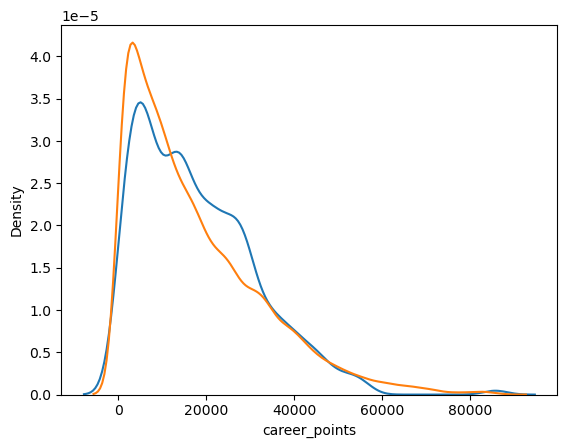

In [28]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="career_points")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="career_points")

<Axes: xlabel='career_duration(days)', ylabel='Density'>

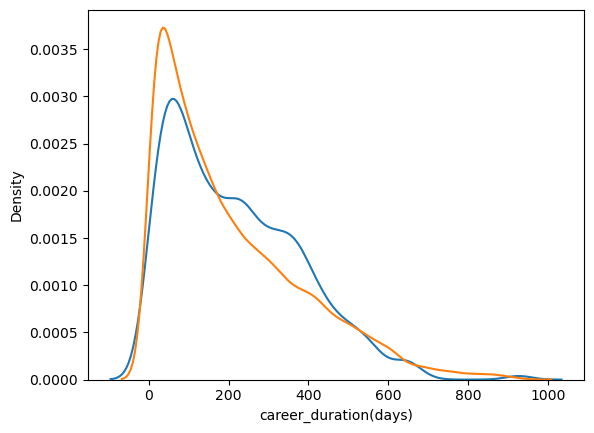

In [29]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="career_duration(days)")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="career_duration(days)")

The model is more sensitive to the selected feature for individuals with lower career_points, which may indicate an interaction between the feature and career performance.

<Axes: xlabel='debut_year', ylabel='Density'>

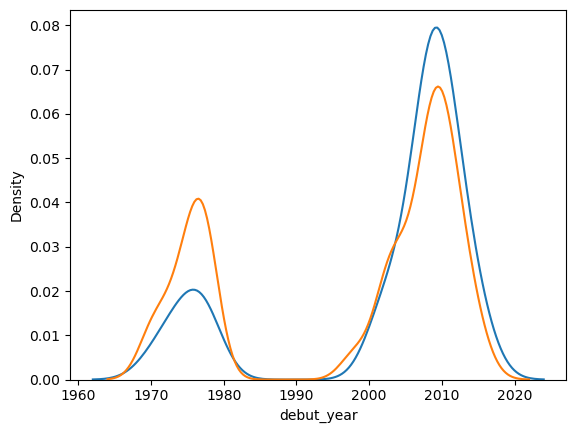

In [30]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="debut_year")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="debut_year")

According to the graph the model attributes greate sensitivity to the debut year for earlier debut years.

<Axes: xlabel='startlist_quality', ylabel='Density'>

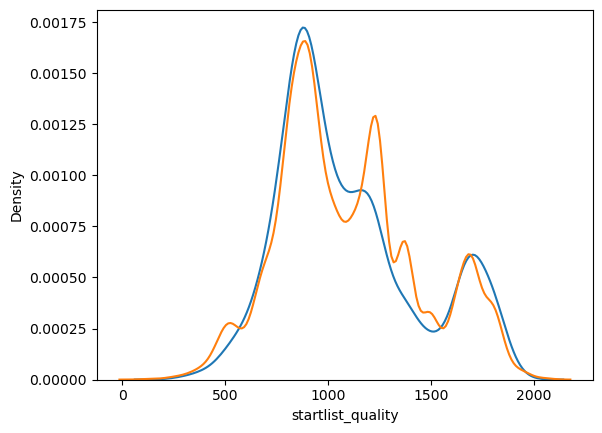

In [31]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="startlist_quality")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="startlist_quality")

<Axes: xlabel='avg_pos', ylabel='Density'>

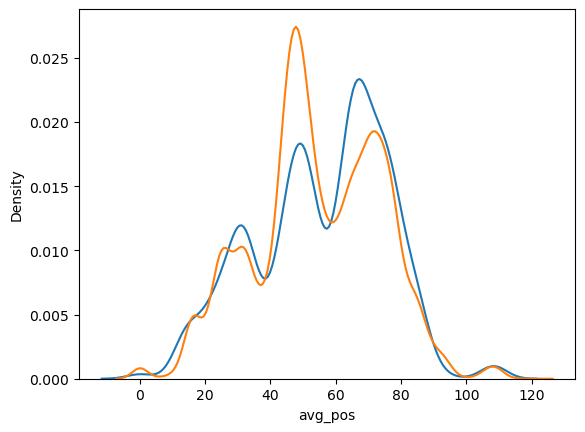

In [32]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="avg_pos")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="avg_pos")

The model has a peak on lower positions (in particular between 40 and 60), so the higly impacted instances tend to have a lower average position.

## Validation
- `Sensitivity to perturbation`: does perturbation in the important features actually impact the model?
- `Iterative removal`: does removing important features worsen the model?
- `Iterative addition`: does adding important features improves the model?


In [33]:
pd.DataFrame(validation)

,0,1,accuracy,macro avg,weighted avg
precision,0.871173,0.419610,0.843727,0.645392,0.805019
recall,0.958668,0.174089,0.843727,0.566379,0.843727
f1-score,0.912829,0.246083,0.843727,0.579456,0.815150
support,30219.000000,5187.000000,0.843727,35406.000000,35406.000000


In [34]:
mean_absolute_importances = interventional_explanations_df.abs().mean()
features_by_importance = interventional_explanations_df.columns[mean_absolute_importances.argsort()].tolist()
features_by_importance

['is_tarmac',
 'climbing_efficiency',
 'difficulty_score',
 'bmi',
 'competitive_age',
 'startlist_quality',
 'career_duration(days)',
 'debut_year',
 'career_points',
 'avg_pos']

We start by constructing a set of corrupted datasets where noise at different magnitudes is inserted into the original dataset...

In [35]:
random_noise = numpy.random.rand(test_data.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_data.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

... then validating the model on it.

In [36]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_labels, xgbc.predict(corruption), output_dict=True)

In [37]:
metric = "f1-score"
corruption_validation = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - validation["weighted avg"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.815150,shap,0.000000
1,is_tarmac,0.2,0.815150,shap,0.000000
2,is_tarmac,0.3,0.815150,shap,0.000000
3,is_tarmac,0.4,0.815150,shap,0.000000
4,is_tarmac,0.5,0.815150,shap,0.000000
...,...,...,...,...,...
85,avg_pos,0.5,0.815215,shap,0.000065
86,avg_pos,0.6,0.815218,shap,0.000067
87,avg_pos,0.7,0.814989,shap,-0.000161
88,avg_pos,0.8,0.814810,shap,-0.000340


In [38]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                              \
                            count      mean           std       min       25%   
feature                                                                         
avg_pos                       9.0  0.815016  1.440793e-04  0.814810  0.814927   
bmi                           9.0  0.814623  1.136662e-03  0.812488  0.814008   
career_duration(days)         9.0  0.815150  1.177569e-16  0.815150  0.815150   
career_points                 9.0  0.815150  1.177569e-16  0.815150  0.815150   
climbing_efficiency           9.0  0.809571  4.487501e-03  0.804223  0.805309   
competitive_age               9.0  0.815150  1.177569e-16  0.815150  0.815150   
debut_year                    9.0  0.815150  1.177569e-16  0.815150  0.815150   
difficulty_score              9.0  0.814298  8.231388e-04  0.813042  0.813911   
is_tarmac                     9.0  0.815150  1.177569e-16  0.815150  0.815150   
startlist_quality             9.0  0.815150  1.177569e-16  0.815150  0.815150   

                                                    difference            \
                            50%       75%       max      count      mean   
feature                                                                    
avg_pos                0.814989  0.815103  0.815218        9.0 -0.000134   
bmi                    0.814857  0.815253  0.816287        9.0 -0.000527   
career_duration(days)  0.815150  0.815150  0.815150        9.0  0.000000   
career_points          0.815150  0.815150  0.815150        9.0  0.000000   
climbing_efficiency    0.809375  0.814309  0.815225        9.0 -0.005579   
competitive_age        0.815150  0.815150  0.815150        9.0  0.000000   
debut_year             0.815150  0.815150  0.815150        9.0  0.000000   
difficulty_score       0.814125  0.814852  0.815381        9.0 -0.000852   
is_tarmac              0.815150  0.815150  0.815150        9.0  0.000000   
startlist_quality      0.815150  0.815150  0.815150        9.0  0.000000   

                                                                         \
                            std       min       25%       50%       75%   
feature                                                                   
avg_pos                0.000144 -0.000340 -0.000223 -0.000161 -0.000047   
bmi                    0.001137 -0.002662 -0.001142 -0.000293  0.000103   
career_duration(days)  0.000000  0.000000  0.000000  0.000000  0.000000   
career_points          0.000000  0.000000  0.000000  0.000000  0.000000   
climbing_efficiency    0.004488 -0.010927 -0.009841 -0.005776 -0.000841   
competitive_age        0.000000  0.000000  0.000000  0.000000  0.000000   
debut_year             0.000000  0.000000  0.000000  0.000000  0.000000   
difficulty_score       0.000823 -0.002109 -0.001239 -0.001025 -0.000298   
is_tarmac              0.000000  0.000000  0.000000  0.000000  0.000000   
startlist_quality      0.000000  0.000000  0.000000  0.000000  0.000000   

                                 
                            max  
feature                          
avg_pos                0.000067  
bmi                    0.001136  
career_duration(days)  0.000000  
career_points          0.000000  
climbing_efficiency    0.000075  
competitive_age        0.000000  
debut_year             0.000000  
difficulty_score       0.000230  
is_tarmac              0.000000  
startlist_quality      0.000000

In [39]:
corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                   \
                      count      mean       std       min       25%      50%   
noise_magnitude                                                                
0.1                    10.0  0.815094  0.000129  0.814852  0.815115  0.81515   
0.2                    10.0  0.815093  0.000250  0.814444  0.815150  0.81515   
0.3                    10.0  0.815074  0.000303  0.814309  0.815150  0.81515   
0.4                    10.0  0.814881  0.001169  0.811740  0.815082  0.81515   
0.5                    10.0  0.814398  0.001808  0.809375  0.814607  0.81515   
0.6                    10.0  0.814067  0.002600  0.806838  0.814381  0.81515   
0.7                    10.0  0.814036  0.003092  0.805309  0.815029  0.81515   
0.8                    10.0  0.813768  0.003258  0.804676  0.814209  0.81515   
0.9                    10.0  0.813558  0.003426  0.804223  0.813513  0.81515   

                                   difference                                \
                     75%       max      count      mean       std       min   
noise_magnitude                                                               
0.1              0.81515  0.815225       10.0 -0.000056  0.000129 -0.000298   
0.2              0.81515  0.815381       10.0 -0.000058  0.000250 -0.000706   
0.3              0.81515  0.815459       10.0 -0.000076  0.000303 -0.000841   
0.4              0.81515  0.816287       10.0 -0.000270  0.001169 -0.003410   
0.5              0.81515  0.815215       10.0 -0.000752  0.001808 -0.005776   
0.6              0.81515  0.815218       10.0 -0.001083  0.002600 -0.008312   
0.7              0.81515  0.815253       10.0 -0.001114  0.003092 -0.009841   
0.8              0.81515  0.815150       10.0 -0.001383  0.003258 -0.010474   
0.9              0.81515  0.815150       10.0 -0.001592  0.003426 -0.010927   

                                               
                      25%  50%  75%       max  
noise_magnitude                                
0.1             -0.000035  0.0  0.0  0.000075  
0.2              0.000000  0.0  0.0  0.000230  
0.3              0.000000  0.0  0.0  0.000309  
0.4             -0.000069  0.0  0.0  0.001136  
0.5             -0.000544  0.0  0.0  0.000065  
0.6             -0.000769  0.0  0.0  0.000067  
0.7             -0.000121  0.0  0.0  0.000103  
0.8             -0.000942  0.0  0.0  0.000000  
0.9             -0.001637  0.0  0.0  0.000000

## Rule explanation

In this part we concentrate on the explanation on the rule explanation of the XGBOOST Model. To do so, we use the `LORE(Local Rule-based Explanations)` algorithm which uses local explanations based on rules for the prediction of the model.

In [40]:
from xailib.explainers.lore_explainer import LoreTabularExplainer

explanation_algorithm = LoreTabularExplainer(xgbc)

configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr":0.1,
    "ngen": 100
}

lore_train_data = pd.concat((train_data, train_labels), axis="columns")
explanation_algorithm.fit(lore_train_data, "top_20", config=configuration)
explanation = explanation_algorithm.explain(train_data.iloc[10000].values)


In [41]:
print(train_data.iloc[10000])

bmi                        20.528922
career_points            4380.000000
career_duration(days)      51.000000
debut_year               1977.000000
difficulty_score            1.318487
competitive_age            25.000000
is_tarmac                   1.000000
climbing_efficiency         0.018229
startlist_quality        1241.000000
avg_pos                    49.039216
Name: 10000, dtype: float64


Now the `explanation` object contains the rules that the model uses to make predictions. We can now get the rules by running the `get_rules` method on the `explanation` object.

In [42]:
explanation.plotRules()

These rules are satsfied by the instance where the model make the prediction, and so the instance is classified as `0`.
If we want to know how to change the classification of the instance from `0` to `1`, we need the counterfactual rules. 

Now we can use the method `getCounterfactualRules` to get the counterfactual rules for the prediction of the model. The counterfactual rules are the rules that need to be satisfied in order to change the prediction of the model. 

In [43]:
explanation.getCounterfactualRules()

[{'premise': [{'att': 'debut_year',
    'op': '<=',
    'thr': 1978.5,
    'is_continuous': True},
   {'att': 'debut_year', 'op': '>', 'thr': 1976.5, 'is_continuous': True},
   {'att': 'avg_pos',
    'op': '<=',
    'thr': 88.05450057983398,
    'is_continuous': True},
   {'att': 'avg_pos',
    'op': '>',
    'thr': 45.07290840148926,
    'is_continuous': True},
   {'att': 'career_points', 'op': '<=', 'thr': 39823.0, 'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '<=',
    'thr': 1189.0,
    'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '>',
    'thr': 1010.0,
    'is_continuous': True},
   {'att': 'competitive_age', 'op': '<=', 'thr': 30.5, 'is_continuous': True},
   {'att': 'career_duration(days)',
    'op': '<=',
    'thr': 463.0,
    'is_continuous': True}],
  'cons': 1,
  'class_name': 'top_20'},
 {'premise': [{'att': 'debut_year',
    'op': '<=',
    'thr': 1992.5,
    'is_continuous': True},
   {'att': 'debut_year', 'op': '>', 'thr': 1976.5

Now with the counterfactual rules we can create counterfactual instances that change the prediction of the model. If the counterfactual rules of the premise are satisfied, the prediction of the model will change. We will do it in the next step.

In [44]:
explanation.expDict["fidelity"]

0.9731140565550176

This fidelity tell us that the local model agrees with the predctions of the global model 99.7% of the synthetic neighbors used to build the local explanation.

## Counterfactual instances

Here we provide the counterfactual explanations for the XGBOOST model. Counterfactual explanations are the instances that need to be changed in order to change the prediction of the model. To do it we use the `dice_ml` library.

In [45]:
import dice_ml

# need to convert data to the Dice format
dice_train_dataset = train_data.copy()
dice_train_dataset["top_20"] = train_labels
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="top_20",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model = dice_ml.Model(
    model=xgbc,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)


In [46]:
# the Dice object interfaces the counterfactual search
explanation_algorithm = dice_ml.Dice(
    dice_dataset,
    dice_model,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:55<00:00, 55.96s/it]


We print the counterfactual explanations generated by DiCE for a specific query instance.

In [47]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.528921,4380.0,51.0,1977.0,1.318487,25,1,0.018229,1241,49.039215,0



Diverse Counterfactual set (new outcome: 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,-,87008.4,-,-,-,-,-,-,-,-,1.0
1,-,-,129.5,-,-,-,-,-,125.0,-,1.0
2,-,35665.5,-,-,-,-,-,-,-,-,1.0
3,23.167673,-,-,-,-,-,0.0,-,-,-,1.0
4,-,71028.3,-,-,-,-,-,-,-,-,1.0
5,20.61875399998972,34688.6,-,-,-,-,-,-,-,-,1.0
6,-,21995.6,-,-,-,-,-,-,-,-,1.0
7,-,-,-,-,-,-,-,-,983.0,-,1.0
8,-,86688.2,-,-,-,-,-,-,-,-,1.0
9,-,58008.4,-,-,-,-,-,-,-,-,1.0


In [48]:
import numpy as np

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=20,  # number of counterfactuals to generate
    permitted_range = {
            "debut_year": (1976.5, 1992.5),         
            "avg_pos": (45.07, 88.05),               
            "career_points": (0, 39823.0),       
            "startlist_quality": (449.0, 934.0),  
            "competitive_age": (0, 30.05),   
            "climbing_efficiency": (0, 0.0214),     
            "career_duration(days)": (0, 338.0)  
    },
    features_to_vary=["debut_year", "avg_pos", "career_points", "startlist_quality", "competitive_age", "career_duration(days)"], 
    stopping_threshold = 0.2
)

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


In [49]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.528921,4380.0,51.0,1977.0,1.318487,25,1,0.018229,1241,49.039215,0



Diverse Counterfactual set (new outcome: 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,-,-,-,-,-,-,-,-,609.0,80.7,1.0
1,-,-,-,-,-,27.0,-,-,572.0,-,1.0
2,-,-,-,-,-,-,-,-,683.0,-,1.0
3,-,19907.1,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,531.0,-,1.0
5,-,34102.9,-,-,-,-,-,-,-,-,1.0
6,-,-,-,-,-,-,-,-,564.0,-,1.0
7,-,16867.5,-,-,-,-,-,-,-,-,1.0
8,-,-,-,-,-,-,-,-,546.0,-,1.0
9,-,28350.3,-,-,-,-,-,-,-,-,1.0


Now we generate the counterfactuals for the XGBOOST model. We take the first instance from `dice_train_dataset` to generate the counterfactuals. 

In [52]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[10000]].drop("top_20", axis="columns"),
    total_CFs=20, # number of counterfactuals to generate
        permitted_range = {
            "debut_year": (1976.5, 1992.5),         
            "avg_pos": (45.07, 88.05),               
            "career_points": (0, 39823.0),       
            "startlist_quality": (449.0, 934.0),  
            "competitive_age": (0, 30.05),   
            "climbing_efficiency": (0, 0.0214),     
            "career_duration(days)": (0, 338.0)  
    },
    features_to_vary=["debut_year", "avg_pos", "career_points", "startlist_quality", "competitive_age", "career_duration(days)"],
    stopping_threshold = 0.2
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:46<00:00, 46.53s/it]


In [53]:
counterfactuals = explanation.cf_examples_list[0].final_cfs_df
counterfactuals

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.528922,29959.3,51.0,1977.0,1.318487,24,1,0.018229,1241,49.039216,1
1,20.528922,30511.9,51.0,1977.0,1.318487,25,1,0.018229,619,49.039216,1
2,20.528922,4380.0,51.0,1985.0,1.318487,25,1,0.018229,533,49.039216,1
3,20.528922,4380.0,51.0,1977.0,1.318487,25,1,0.018229,660,49.039216,1
4,20.528922,37463.8,51.0,1977.0,1.318487,25,1,0.018229,1241,45.500000,1
5,20.528922,4380.0,51.0,1989.0,1.318487,25,1,0.018229,597,49.039216,1
6,20.528922,4380.0,51.0,1977.0,1.318487,25,1,0.018229,580,49.039216,1
7,20.528922,39285.7,51.0,1977.8,1.318487,25,1,0.018229,1241,49.039216,1
8,20.528922,4380.0,51.0,1977.0,1.318487,25,1,0.018229,594,74.800000,1
9,20.528922,6123.6,51.0,1977.0,1.318487,25,1,0.018229,592,49.039216,1
